## **Age Verification Model for Alcohol Sales**

### PART 1: IMPORT LIBRARIES 

In [2]:
import os
import numpy as np
import cv2
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tarfile
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from sklearn.metrics import precision_score, recall_score
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from PIL import Image

### PART 2: LOADING AND PREPROCESSING DATA

This following code extracts image files from multiple compressed archives into a single organized directory. 
We're combining images from multiple source files into one working directory and flattening the directory structure by removing nested folders for easier access to all images. 

Extracted part1.tar.gz into all_images
Extracted part2.tar.gz into all_images
Extracted part3.tar.gz into all_images
Total JPG images extracted: 24106


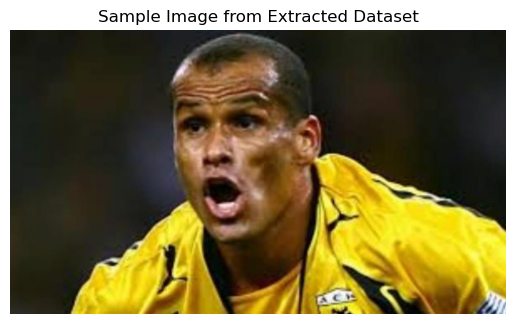

In [3]:
# Load Data 
# Define source tar files and the extraction folder
tar_files = ["part1.tar.gz", "part2.tar.gz", "part3.tar.gz"]
extract_path = "all_images"
os.makedirs(extract_path, exist_ok=True)

# Extract each tar.gz file, flattening the directory structure
for tar_file in tar_files:
    if os.path.exists(tar_file):
        with tarfile.open(tar_file, "r:gz") as tar:
            for member in tar.getmembers():
                if member.isfile():  # Only extract files, not directories
                    # Use only the base name to flatten the directory structure
                    filename = os.path.basename(member.name)
                    dest_path = os.path.join(extract_path, filename)
                    
                    # If a file with the same name exists, rename to avoid collisions
                    counter = 1
                    base, ext = os.path.splitext(filename)
                    while os.path.exists(dest_path):
                        dest_path = os.path.join(extract_path, f"{base}_{counter}{ext}")
                        counter += 1

                    # Extract the file's content and write it to the destination
                    file_obj = tar.extractfile(member)
                    if file_obj:
                        with open(dest_path, "wb") as out_f:
                            out_f.write(file_obj.read())
        print(f"Extracted {tar_file} into {extract_path}")

# List all JPG images in the extract_path folder
jpg_files = [os.path.join(extract_path, f) for f in os.listdir(extract_path) if f.lower().endswith(".jpg")]
print(f"Total JPG images extracted: {len(jpg_files)}")

# Load and display a sample image
if jpg_files:
    sample_img_path = jpg_files[0]
    img = Image.open(sample_img_path)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Sample Image from Extracted Dataset")
    plt.show()
else:
    print("No JPG files found in the extracted folder.")

In the follwoing part of the code:
- We standardize all images to 224×224 pixels because this is the input size our pretrained model EfficientNetB0 expects
- We use RGB color space (converting from BGR) as this is standard for most deep learning models
- We use EfficientNet's preprocessing function to ensure pixel values are normalized properly
- We create a binary classification problem: 0 for underage, 1 for adult as it is the primary goal of our business case

In [4]:
# Define paths to dataset folders
extract_paths = ["all_images"]
images = []
labels = []

# Load images and apply EfficientNetB0 preprocessing
print("Loading and preprocessing images...")
for extract_path in extract_paths:
    for root, _, files in os.walk(extract_path):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                img_path = os.path.join(root, file)
                try:
                    # Extract age from filename
                    age = int(file.split("_")[0])
                    
                    # Read image, convert to RGB, resize to (224,224) and preprocess
                    img = cv2.imread(img_path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (224, 224))
                    img = preprocess_input(img)  # Normalization for EfficientNetB0
                    
                    # Label: 0 = Underage (age < 18), 1 = Adult (age ≥ 18)
                    label = 0 if age < 18 else 1
                    
                    images.append(img)
                    labels.append(label)
                except Exception as e:
                    print(f"Skipping file: {file} due to error: {e}")

# Convert lists to NumPy arrays
images = np.array(images, dtype="float32")
labels = np.array(labels)

# Count the number of underage and adult labels
underage_count = np.sum(labels == 0)
adult_count = np.sum(labels == 1)
print(f"Number of underage images: {underage_count}")
print(f"Number of adult images: {adult_count}")

Loading and preprocessing images...


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code


Number of underage images: 4527
Number of adult images: 19579


### PART 3: DATASET BALANCING AND SPLITTING 

Our dataset has more adult images than underage images. Imbalanced datasets can cause the model to be biased toward the majority class. We randomly select adult images to match the number of underage images. This ensures the model learns to distinguish both classes equally well. 

This approach also reduces computational requirements, as our hardware isn't powerful enough to process the full dataset of 24 106 images. Balancing classes lets us build an effective model with fewer total images while maintaining performance.

In [5]:
# Get indices for each class
underage_indices = np.where(labels == 0)[0]
adult_indices = np.where(labels == 1)[0]

# Balance the dataset by taking all underage samples and an equal number of adult samples
desired_count = len(underage_indices)
print(f"Balancing dataset to {desired_count} samples per class...")

# Randomly select a subset of adult indices
np.random.seed(42)  # For reproducibility
selected_adult_indices = np.random.choice(adult_indices, size=desired_count, replace=False)

# Combine the underage indices with the selected adult indices
balanced_indices = np.concatenate([underage_indices, selected_adult_indices])
np.random.shuffle(balanced_indices)

# Create the balanced datasets
balanced_images = images[balanced_indices]
balanced_labels = labels[balanced_indices]
print("Balanced dataset shape:", balanced_images.shape, balanced_labels.shape)

Balancing dataset to 4527 samples per class...


Balanced dataset shape: (9054, 224, 224, 3) (9054,)


In [6]:
# Split dataset into training, validation, and testing sets (80%, 10%, 10%)
print("Splitting dataset into train, validation, and test sets...")
X_train, X_temp, y_train, y_temp = train_test_split(
    balanced_images, 
    balanced_labels, 
    test_size=0.2,  # 20% for temp set
    random_state=42, 
    stratify=balanced_labels  # Maintain class balance
)

# Split the temp set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, 
    y_temp, 
    test_size=0.5,  # Half of temp (10% of total) for test
    random_state=42, 
    stratify=y_temp  # Maintain class balance
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Splitting dataset into train, validation, and test sets...


Training set: 7243 samples
Validation set: 905 samples
Test set: 906 samples


### PART 4: MODEL DEFINITION AND COMPILATION

In [7]:
# Clear any previous models from memory
tf.keras.backend.clear_session()

We use transfer learning with EfficientNetB0, which is pre-trained on ImageNet. EfficientNet offers strong performance with relatively few parameters. We freeze the early layers which detect basic features (edges, textures) and unfreeze the last 20 layers to fine-tune them for our specific age classification task. This approach lets us leverage general image features while adapting to our specific task. 

GlobalAveragePooling2D reduces spatial dimensions and parameter count. Multiple dense layers give the model capacity to learn complex age-related features. BatchNormalization helps training stability and convergence. Dropout layers (50% and 30%) prevent overfitting by randomly dropping neurons during training. L2 regularization further prevents overfitting by penalizing large weights and final sigmoid activation gives us a probability output between 0-1 for binary classification. 

In [8]:
# Define model using EfficientNetB0 as a pre-trained base
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Set trainable status for each layer
for layer in base_model.layers[:-20]:  # Keep first N layers frozen
    layer.trainable = False
for layer in base_model.layers[-20:]:  # Unfreeze final 20 layers
    layer.trainable = True

# Create model with carefully tuned regularization
model = Sequential([
    base_model,
    GlobalAveragePooling2D(), # Global pooling to reduce spatial dimensions
    Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.005)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation="sigmoid", kernel_regularizer=regularizers.l2(0.01))
])

# Print model summary to verify architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        

We implement focal loss to improve the model's performance on difficult examples by down-weighting easy-to-classify examples (controlled by gamma) and reduce false positives by placing higher emphasis on correctly classifying the underage class. Aplha serves as a weighting factor that helps address class imbalance, we have a balanced dataset, thas is why our alpha equals 0.5. This helps our model perform better on borderline cases (like teenagers) and minimize critical misclassifications.

In [9]:
# Define focal loss function
import tensorflow as tf
from tensorflow.keras import backend as K

def focal_loss(gamma=2.0, alpha=0.5):
    def focal_loss_fixed(y_true, y_pred):
        # Clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        
        # Calculate focal loss
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        loss = -alpha * K.pow(1 - pt, gamma) * K.log(pt)
        return K.mean(loss)
    
    return focal_loss_fixed

In [10]:
# Compile the model
print("Compiling model...")
optimizer_adam = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(
 optimizer=optimizer_adam,
 loss=focal_loss(gamma=2.0, alpha=0.5),  # Using focal loss instead of binary_crossentropy
 metrics=["accuracy"]
)

Compiling model...


### PART 5: CALLBACKS DEFINITION

In [11]:
# Live plotting callback to visualize training progress
class LiveLossPlot(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epochs = []
        self.train_losses = []
        self.val_losses = []
        self.train_acc = []
        self.val_acc = []

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs.append(epoch)
        self.train_losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.train_acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        
        # Clear previous output and create new plot
        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Plot Loss
        ax1.plot(self.epochs, self.train_losses, label='Training Loss')
        ax1.plot(self.epochs, self.val_losses, label='Validation Loss')
        ax1.set_title('Loss per Epoch')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        
        # Plot Accuracy
        ax2.plot(self.epochs, self.train_acc, label='Training Accuracy')
        ax2.plot(self.epochs, self.val_acc, label='Validation Accuracy')
        ax2.set_title('Accuracy per Epoch')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        
        plt.show()


In [12]:

# Function to display final training history as a table
def display_history(history):
    print("\n====== Epoch History ======")
    print(f"{'Epoch':<6} {'Train Loss':<12} {'Val Loss':<12} {'Train Acc':<12} {'Val Acc':<12}")
    print("-" * 60)

    for i, (loss, val_loss, acc, val_acc) in enumerate(zip(
        history.history['loss'],
        history.history['val_loss'],
        history.history['accuracy'],
        history.history['val_accuracy']
    )):
        print(f"{i:<6} {loss:<12.6f} {val_loss:<12.6f} {acc:<12.6f} {val_acc:<12.6f}")

ReduceLROnPlateau automatically reduces the learning rate when progress plateaus. This helps the model escape local minima and find better solutions. Early stopping prevents overfitting by stopping training when validation loss stops improving. We save the best model based on validation loss, not training loss. This ensures we keep the version with the best generalization performance.

In [13]:
# Learning rate scheduler callback using ReduceLROnPlateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,          # Reduce the learning rate by half
    patience=2,          # Wait for 2 epochs with no improvement before reducing
    min_lr=1e-6          # Lower bound on the learning rate
)

In [14]:
# Early stopping callback
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=8, 
    restore_best_weights=True
)

In [15]:
# Model checkpoint callback that saves the best model based on validation loss
checkpoint_callback = ModelCheckpoint(
    "version_2051.h5",  # File name for the saved model
    monitor="val_loss",  # Monitor the validation loss
    mode="min",         # Lower val_loss is better
    save_best_only=True,  # Save only the best model
    verbose=1
)

#### PART 6: MODEL TRAINING

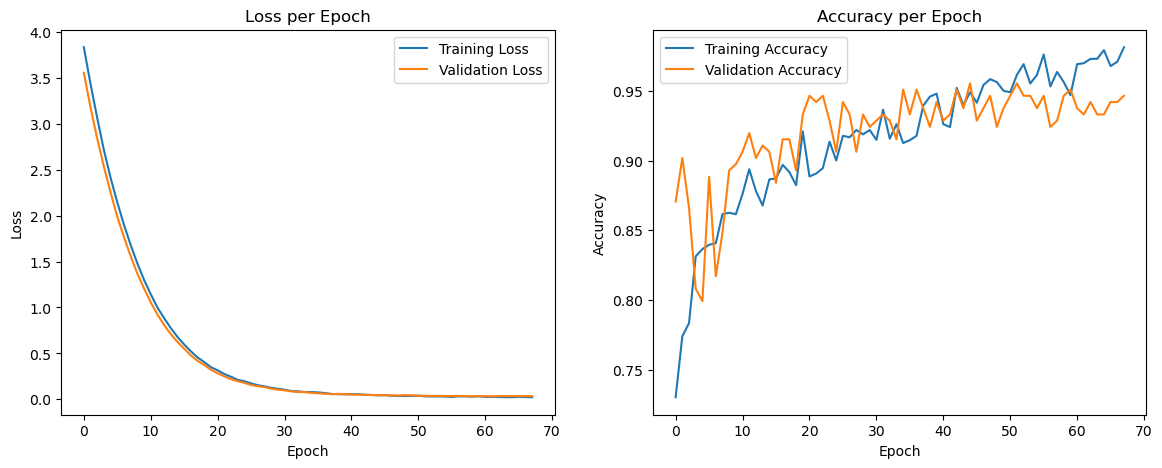


Epoch 68: val_loss did not improve from 0.03308
30/30 [==============================] - 11s 359ms/step - loss: 0.0229 - accuracy: 0.9812 - val_loss: 0.0352 - val_accuracy: 0.9464 - lr: 7.8125e-06


In [16]:
live_plot = LiveLossPlot()
# Train the model
history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=100, 
    batch_size=32, 
    steps_per_epoch=30, 
    validation_steps=7, 
    callbacks=[live_plot, reduce_lr, checkpoint_callback, early_stopping_cb]
)

### PART 7: DISPLAY TRAINING RESULTS

In [17]:
# Display epoch history as a table
print("====== Epoch History ======")
print(f"{'Epoch':<6} {'Train Loss':<12} {'Val Loss':<12} {'Train Acc':<12} {'Val Acc':<12}")
print("-" * 60)
for i, (loss, val_loss, acc, val_acc) in enumerate(zip(
    history.history['loss'],
    history.history['val_loss'],
    history.history['accuracy'],
    history.history['val_accuracy']
)):
    print(f"{i:<6} {loss:<12.6f} {val_loss:<12.6f} {acc:<12.6f} {val_acc:<12.6f}")

====== Epoch History ======
Epoch  Train Loss   Val Loss     Train Acc    Val Acc     
------------------------------------------------------------
0      3.833428     3.554485     0.730208     0.870536    
1      3.434978     3.179204     0.773958     0.901786    
2      3.064273     2.839556     0.783333     0.866071    
3      2.714545     2.533031     0.831250     0.808036    
4      2.412102     2.252024     0.836458     0.799107    
5      2.145130     1.988269     0.839583     0.888393    
6      1.900297     1.766197     0.840625     0.816964    
7      1.680579     1.558657     0.861555     0.848214    
8      1.479673     1.368147     0.862500     0.892857    
9      1.301540     1.206970     0.861458     0.897321    
10     1.144874     1.056550     0.876042     0.906250    
11     0.999553     0.923461     0.893750     0.919643    
12     0.884586     0.809915     0.878125     0.901786    
13     0.775221     0.709418     0.867708     0.910714    
14     0.679200     0.6241

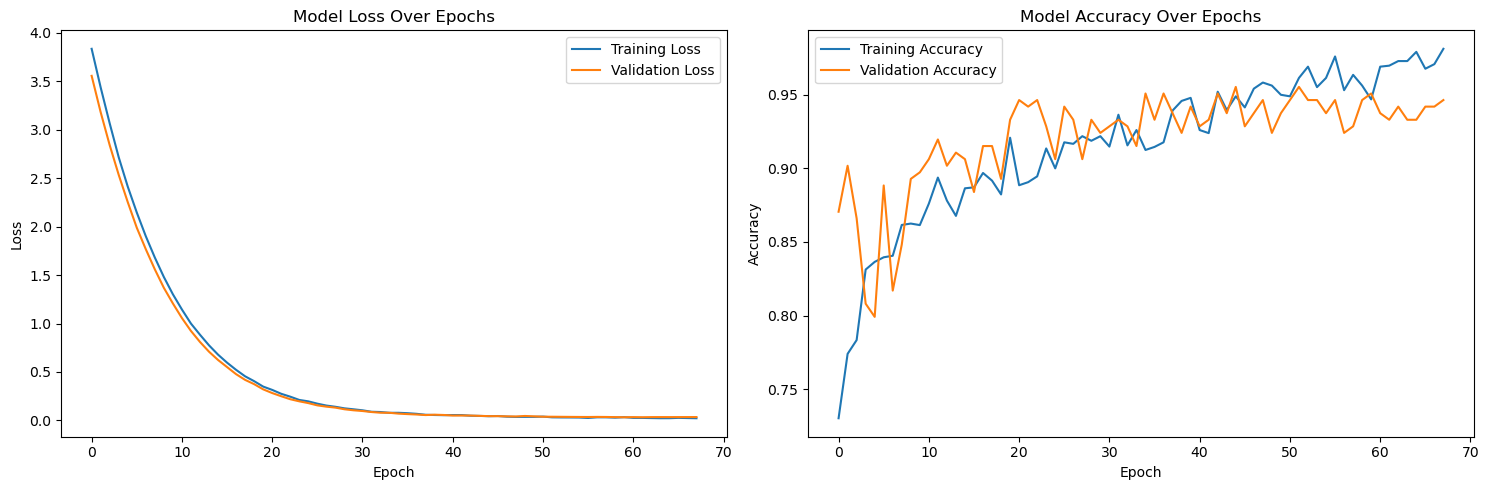

In [18]:
# Plot Training History
plt.figure(figsize=(15, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
# Load the model with custom objects as we used focal loss
best_model = load_model("version_2051.h5", 
                      custom_objects={'focal_loss_fixed': focal_loss(gamma=2.0, alpha=0.5)})

# Evaluate the best model
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

29/29 [==============================] - 8s 244ms/step - loss: 0.0460 - accuracy: 0.9260
Test Accuracy: 0.93


In [20]:
# Load the model with custom objects as we used focal loss
best_model = load_model("version_2051.h5", 
                      custom_objects={'focal_loss_fixed': focal_loss(gamma=2.0, alpha=0.5)})

# Calculate predictions for test set
y_test_pred_prob = best_model.predict(X_test)  # Use best_model instead of model
y_test_pred = (y_test_pred_prob > 0.7).astype(int).flatten()

# Calculate and print metrics for test set
test_accuracy = (y_test_pred == y_test).mean()
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)

print("\n====== Test Set Metrics ======")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Create confusion matrix for test set
from sklearn.metrics import confusion_matrix
test_cm = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = test_cm.ravel()

print("\n====== Test Set Confusion Matrix ======")
print(f"True Negatives (Underage correctly classified): {tn}")
print(f"False Positives (Underage classified as Adult): {fp}")
print(f"False Negatives (Adult classified as Underage): {fn}")
print(f"True Positives (Adult correctly classified): {tp}")

29/29 [==============================] - 7s 222ms/step

====== Test Set Metrics ======
Accuracy: 0.8852
Precision: 0.9486
Recall: 0.8146
F1 Score: 0.8765

====== Test Set Confusion Matrix ======
True Negatives (Underage correctly classified): 433
False Positives (Underage classified as Adult): 20
False Negatives (Adult classified as Underage): 84
True Positives (Adult correctly classified): 369
